<ul>
  <li>Ilyes Tebourski</li>
  <li>Julien Maille-Paez</li>
  <li>Mohammed Mawassy</li>
</ul>


<h2 style="text-align: center;">HoML Projet: Classification of NBA Basketball Player Positions (1950s-Present)</h1>


In basketball, there are five well-defined roles for each player on the court.

However, in the NBA, a league that has spanned over several decades, the rules have evolved, and players have changed the way the game is played. This project involves analyzing the evolution of the game. 

Much like people who claim that there are no longer distinct seasons, many say that defined roles in the NBA have become obsolete and that today's players are more versatile.

The question is whether this observation can be substantiated by data. We will explore this through the metric of the following classification task: Determining a player's role on the court based on their seasonal statistics

Was this analysis easier in the past when roles were apparently more defined? Is it more challenging now, with players becoming increasingly versatile?

This sports analysis also aims to address the rcurring question among basketball fans: "Has the NBA evolved into a positionless league?"

We will see if this evolution of the game is shown in this classification task.


<span style="color:red; font-weight:bold;">
This is the final version of the notebook
</span>


Slides : https://docs.google.com/presentation/d/1i_43Tc21H1mhh9p-Uq_SRwtlG6FNtjEvDdo_rx8_Oeg/edit?usp=sharing

Data : https://www.kaggle.com/datasets/drgilermo/nba-players-stats

**Imports:**

In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

**Functions used:**


In [15]:
def feet_to_cm(height): #not used
    if pd.isna(height):
        return np.nan
    feet, inches = map(int, height.split('-'))
    return feet * 30.48 + inches * 2.54

def create_datasets_per_year(data):
    years = range(1950, 2019)
    yearly_datasets = {year: data[data['Year'] == year] for year in years}
    return yearly_datasets

def columns_w_missing_val(data):
    missing_val = {}
    for year, df in data.items():
        missing_val[year] = df.isnull().any().sum()
    return missing_val

**Loading data:**

Our project involves two datasets:

1. **Seasonal Statistics (24691x53):** It has seasonal stats of NBA players from 1950 to 2018.
2. **Personal Information (3922x8):** It contains personal details of the players.

In [16]:
dataP = pd.read_csv('Players.csv')
data = pd.read_csv('Seasons_Stats.csv')

**Pre-processing:**

First, let's look at the first dataset

In [17]:
dataP

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky
...,...,...,...,...,...,...,...,...
3917,3917,Troy Williams,198.0,97.0,South Carolina State University,1969.0,Columbia,South Carolina
3918,3918,Kyle Wiltjer,208.0,108.0,Gonzaga University,1992.0,Portland,Oregon
3919,3919,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",1996.0,Hendersonville,Tennessee
3920,3920,Paul Zipser,203.0,97.0,NaN,1994.0,Heidelberg,Germany


We see that the only information that will be useful to us in our project is 'height' and 'weight'. Let's extract them and remove the incomplete data

In [18]:
print(dataP.isnull().sum())

Unnamed: 0       0
Player           1
height           1
weight           1
collage        349
born             1
birth_city     470
birth_state    483
dtype: int64


We delete the columns we don't need that are missing information. For the columns 'height' and 'weight' which are useful, we remove any rows where information is missing

In [19]:
dataP = dataP.drop(['Unnamed: 0','born','collage','birth_city','birth_state'], axis=1)
dataP = dataP.dropna()
dataP

,Player,height,weight
0,Curly Armstrong,180.0,77.0
1,Cliff Barker,188.0,83.0
2,Leo Barnhorst,193.0,86.0
3,Ed Bartels,196.0,88.0
4,Ralph Beard,178.0,79.0
...,...,...,...
3917,Troy Williams,198.0,97.0
3918,Kyle Wiltjer,208.0,108.0
3919,Stephen Zimmerman,213.0,108.0
3920,Paul Zipser,203.0,97.0


In [20]:
len(dataP['Player'].unique())

3921

In [21]:
len(data['Player'].unique())

3922

The two datasets seem to have the same players. Let's check to be sure


In [22]:
dataset1 = set(data['Player'].unique())
dataset2 = set(dataP['Player'].unique())

common = dataset1.intersection(dataset2)

total = len(common)

print(f"number of common players : {total}")

number of common players : 3921


Indeed they have.

Now, let's merge the datasets to add 'height' and 'weight'.

In [23]:
data

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


In [24]:
data = pd.merge(data, dataP, on='Player', how='inner')

Here's the new dataset we're going to work on:

In [25]:
data

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,180.0,77.0
1,314,1951.0,Curly Armstrong,G-F,32.0,FTW,38.0,NaN,NaN,NaN,...,NaN,89.0,77.0,NaN,NaN,NaN,97.0,202.0,180.0,77.0
2,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,188.0,83.0
3,315,1951.0,Cliff Barker,SG,30.0,INO,56.0,NaN,NaN,NaN,...,NaN,100.0,115.0,NaN,NaN,NaN,98.0,152.0,188.0,83.0
4,489,1952.0,Cliff Barker,SG,31.0,INO,44.0,NaN,494.0,10.8,...,NaN,81.0,70.0,NaN,NaN,NaN,56.0,126.0,188.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24619,24674,2017.0,Troy Williams,SF,22.0,HOU,6.0,3.0,139.0,12.8,...,15.0,24.0,6.0,3.0,1.0,6.0,18.0,58.0,198.0,97.0
24620,24675,2017.0,Kyle Wiltjer,PF,24.0,HOU,14.0,0.0,44.0,6.7,...,6.0,10.0,2.0,3.0,1.0,5.0,4.0,13.0,208.0,108.0
24621,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,213.0,108.0
24622,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,203.0,97.0


Now, let's check the data types to see what we can do with them.

In [26]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24624 entries, 0 to 24623
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24624 non-null  int64  
 1   Year        24624 non-null  float64
 2   Player      24624 non-null  object 
 3   Pos         24624 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24624 non-null  object 
 6   G           24624 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24138 non-null  float64
 9   PER         24101 non-null  float64
 10  TS%         24538 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24525 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-nul

Let's check for any null values.

In [27]:
print(data.isnull().sum())

Unnamed: 0        0
Year              0
Player            0
Pos               0
Age               8
Tm                0
G                 0
GS             6391
MP              486
PER             523
TS%              86
3PAr           5785
FTr              99
ORB%           3832
DRB%           3832
TRB%           3053
AST%           2069
STL%           3832
BLK%           3832
TOV%           5042
USG%           4984
blanl         24624
OWS              39
DWS              39
WS               39
WS/48           523
blank2        24624
OBPM           3827
DBPM           3827
BPM            3827
VORP           3827
FG                0
FGA               0
FG%              99
3P             5697
3PA            5697
3P%            9208
2P                0
2PA               0
2P%             128
eFG%             99
FT                0
FTA               0
FT%             858
ORB            3827
DRB            3827
TRB             312
AST               0
STL            3827
BLK            3827


We notice that the null data is not evenly distributed. This is probably because in 1950, fewer advanced stats were tracked compared to 2018. We'll address this issue later.

Let's check for any outliers in the data.

In [28]:
print(data.min())
print(data.max())

Unnamed: 0             0
Year              1950.0
Player        A.C. Green
Pos                    C
Age                 18.0
Tm                   AND
G                    1.0
GS                   0.0
MP                   0.0
PER                -90.6
TS%                  0.0
3PAr                 0.0
FTr                  0.0
ORB%                 0.0
DRB%                 0.0
TRB%                 0.0
AST%                 0.0
STL%                 0.0
BLK%                 0.0
TOV%                 0.0
USG%                 0.0
blanl                NaN
OWS                 -5.1
DWS                 -1.0
WS                  -2.8
WS/48             -2.519
blank2               NaN
OBPM               -73.8
DBPM               -30.4
BPM                -86.7
VORP                -2.6
FG                   0.0
FGA                  0.0
FG%                  0.0
3P                   0.0
3PA                  0.0
3P%                  0.0
2P                   0.0
2PA                  0.0
2P%                  0.0


Let's remove the clearly unnecessary non-numeric data from the dataset.

In [29]:
print(data.columns)

data = data.drop(['blank2','blanl','Unnamed: 0','Player','Tm'], axis=1)

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'height', 'weight'],
      dtype='object')


In [30]:
print(data.columns)

Index(['Year', 'Pos', 'Age', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'height',
       'weight'],
      dtype='object')


There's one non-numeric data column left, but it's useful: the "Pos" column, which we want to determine. Let's check its values.

In [31]:
position_counts = data['Pos'].value_counts()
print(position_counts)

Pos
PF       4966
SG       4811
C        4759
SF       4699
PG       4648
G         139
F         123
F-C        81
G-F        79
F-G        60
C-F        35
C-PF       33
SF-SG      30
PG-SG      28
PF-C       27
SG-PG      27
SG-SF      26
PF-SF      25
SF-PF      21
SG-PF       3
C-SF        2
SF-PG       1
PG-SF       1
Name: count, dtype: int64


We see there are more than 5 because sometimes people write positions differently, especially during the old days. So, we're going to merge them into 5 categories. No need to explain all the mapping, but there are many variants in terms of position names, and I've put them into their closest position.

In [32]:
position_mapping = {

    'G'    : 'PG',
    'F'    : 'SF',
    'F-C'  : 'PF',
    'G-F'  : 'SG',
    'F-G'  : 'SF',
    'C-F'  : 'PF',
    'C-PF' : 'C' ,
    'SF-SG': 'SF',
    'PG-SG': 'PG',
    'SG-PG': 'SG', 
    'PF-C' : 'PF',
    'SG-SF': 'SG',
    'PF-SF': 'PF',
    'SF-PF': 'SF', 
    'SG-PF': 'SG',
    'C-SF' : 'C' ,
    'SF-PG': 'SF',
    'PG-SF': 'PG'
}

data['Pos'] = data['Pos'].replace(position_mapping)




We prefer to use values PF, SG, SF instead of PG and C when we had the choice to distort the dataset less, aiming for more uniformity and less weight on the extremes because there's less chance of making mistakes.

In [33]:
position_counts = data['Pos'].value_counts()
print(position_counts)

Pos
PF    5134
SG    4946
SF    4934
PG    4816
C     4794
Name: count, dtype: int64


We notice that our target data is very well distributed, which is a very good sign.

Some notions about player positions:

- **PG (Point Guard):** Generally smaller, quick players skilled in passing and shooting from distance.
- **SG (Shooting Guard):** Versatile players, known for their shooting abilities.
- **SF (Small Forward):** Athletic players blending size and speed.
- **PF (Power Forward):** Larger, stronger players focused on rebounding and close-range play.
- **C (Center):** The tallest players, dominating near the basket.

After this categorization, we converted these position values into numeric form, ranging from 1 to 5. We chose not to use one-hot encoding because some positions are more closely related than others, with 5 being closer to the basket and 1 being farther away, just like in football with attacker/midfield/defender. (edit: apparently this does not matter when doing a classification and not a regression?)

In [34]:
position_mapping = {
    'C' : 5,
    'PG': 1,
    'SF': 3,
    'SG': 2,
    'PF': 4
}

data['Pos'] = data['Pos'].replace(position_mapping)


We've fixed the problem with non-numeric values. Now, all that's left is to normalize and address the issue of missing values.

In [35]:
data

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,1950.0,2,31.0,63.0,NaN,NaN,NaN,0.368,NaN,0.467,...,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,180.0,77.0
1,1951.0,2,32.0,38.0,NaN,NaN,NaN,0.372,NaN,0.388,...,NaN,89.0,77.0,NaN,NaN,NaN,97.0,202.0,180.0,77.0
2,1950.0,2,29.0,49.0,NaN,NaN,NaN,0.435,NaN,0.387,...,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,188.0,83.0
3,1951.0,2,30.0,56.0,NaN,NaN,NaN,0.322,NaN,0.381,...,NaN,100.0,115.0,NaN,NaN,NaN,98.0,152.0,188.0,83.0
4,1952.0,2,31.0,44.0,NaN,494.0,10.8,0.343,NaN,0.317,...,NaN,81.0,70.0,NaN,NaN,NaN,56.0,126.0,188.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24619,2017.0,3,22.0,6.0,3.0,139.0,12.8,0.616,0.477,0.159,...,15.0,24.0,6.0,3.0,1.0,6.0,18.0,58.0,198.0,97.0
24620,2017.0,4,24.0,14.0,0.0,44.0,6.7,0.437,0.929,0.143,...,6.0,10.0,2.0,3.0,1.0,5.0,4.0,13.0,208.0,108.0
24621,2017.0,5,20.0,19.0,0.0,108.0,7.3,0.346,0.000,0.161,...,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,213.0,108.0
24622,2017.0,3,22.0,44.0,18.0,843.0,6.9,0.503,0.448,0.181,...,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,203.0,97.0


We've decided to standardize the quantities (the unbounded values) and normalize the percentages and bounded values.

In [36]:
standardiser = ['G','height', 'height','GS','MP','PER','3PAr','FTr','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
normaliser = ['FG%', '3P%', 'FT%','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','2P%','eFG%']

norm = MinMaxScaler()
data[normaliser] = norm.fit_transform(data[normaliser])
data[normaliser] = norm.fit_transform(data[normaliser])



std = StandardScaler()
data[standardiser] = std.fit_transform(data[standardiser])
data[standardiser] = norm.fit_transform(data[standardiser])

In [37]:
data

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,1950.0,2,31.0,0.712644,NaN,NaN,NaN,0.323944,NaN,0.077833,...,NaN,NaN,0.151203,NaN,NaN,NaN,0.562176,0.113676,0.281690,77.0
1,1951.0,2,32.0,0.425287,NaN,NaN,NaN,0.327465,NaN,0.064667,...,NaN,0.041415,0.066151,NaN,NaN,NaN,0.251295,0.050137,0.281690,77.0
2,1950.0,2,29.0,0.551724,NaN,NaN,NaN,0.382923,NaN,0.064500,...,NaN,NaN,0.093643,NaN,NaN,NaN,0.256477,0.069248,0.394366,83.0
3,1951.0,2,30.0,0.632184,NaN,NaN,NaN,0.283451,NaN,0.063500,...,NaN,0.046533,0.098797,NaN,NaN,NaN,0.253886,0.037726,0.394366,83.0
4,1952.0,2,31.0,0.494253,NaN,0.127254,0.461538,0.301937,NaN,0.052833,...,NaN,0.037692,0.060137,NaN,NaN,NaN,0.145078,0.031273,0.394366,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24619,2017.0,3,22.0,0.057471,0.036145,0.035806,0.470642,0.542254,0.477,0.026500,...,0.013501,0.011168,0.005155,0.009967,0.002193,0.012931,0.046632,0.014396,0.535211,97.0
24620,2017.0,4,24.0,0.149425,0.000000,0.011334,0.442877,0.384683,0.929,0.023833,...,0.005401,0.004653,0.001718,0.009967,0.002193,0.010776,0.010363,0.003227,0.676056,108.0
24621,2017.0,5,20.0,0.206897,0.000000,0.027821,0.445608,0.304577,0.000,0.026833,...,0.021602,0.016287,0.003436,0.006645,0.010965,0.006466,0.044041,0.005709,0.746479,108.0
24622,2017.0,3,22.0,0.494253,0.216867,0.217156,0.443787,0.442782,0.448,0.030167,...,0.099010,0.058167,0.030928,0.049834,0.035088,0.086207,0.202073,0.059568,0.605634,97.0


Here we are at our final and main problem of our preprocessing:

The null data is not evenly distributed.

Here's what we'll do:

Create datasets by year, then group the years based on the number of empty values.

By making the largest possible packets, we can then refine them.

In essence, year by year, the NBA began tracking more and more statistics, so the evolution of the number of empty columns is quite gradual from year to year. What we want is to compare the data in the fairest way possible, on an equal footing. We need to find this balance.

In [38]:
yearly_data = create_datasets_per_year(data)

In [39]:
yearly_data[1950]

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,1950.0,2,31.0,0.712644,NaN,NaN,NaN,0.323944,NaN,0.077833,...,NaN,NaN,0.151203,NaN,NaN,NaN,0.562176,0.113676,0.281690,77.0
2,1950.0,2,29.0,0.551724,NaN,NaN,NaN,0.382923,NaN,0.064500,...,NaN,NaN,0.093643,NaN,NaN,NaN,0.256477,0.069248,0.394366,83.0
5,1950.0,3,25.0,0.758621,NaN,NaN,NaN,0.346831,NaN,0.043167,...,NaN,NaN,0.120275,NaN,NaN,NaN,0.497409,0.108712,0.464789,86.0
10,1950.0,3,24.0,0.160920,NaN,NaN,NaN,0.274648,NaN,0.065833,...,NaN,NaN,0.017182,NaN,NaN,NaN,0.075130,0.015637,0.507042,88.0
11,1950.0,3,24.0,0.137931,NaN,NaN,NaN,0.271127,NaN,0.063000,...,NaN,NaN,0.017182,NaN,NaN,NaN,0.069948,0.014644,0.507042,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,1950.0,1,28.0,0.758621,NaN,NaN,NaN,0.453345,NaN,0.095333,...,NaN,NaN,0.183849,NaN,NaN,NaN,0.264249,0.196327,0.323944,77.0
762,1950.0,1,23.0,0.632184,NaN,NaN,NaN,0.341549,NaN,0.057667,...,NaN,NaN,0.091924,NaN,NaN,NaN,0.365285,0.106478,0.211268,70.0
763,1950.0,1,26.0,0.413793,NaN,NaN,NaN,0.370599,NaN,0.095833,...,NaN,NaN,0.042096,NaN,NaN,NaN,0.069948,0.019111,0.211268,70.0
764,1950.0,1,28.0,0.057471,NaN,NaN,NaN,0.213028,NaN,0.011833,...,NaN,NaN,0.000859,NaN,NaN,NaN,0.015544,0.001737,0.211268,70.0


Now let's observe how the missing data is distributed.

In [40]:
missing_values_per_year = columns_w_missing_val(yearly_data)

for year, count in missing_values_per_year.items():
    print(f"{year} : {count} ")


1950 : 27 
1951 : 29 
1952 : 27 
1953 : 29 
1954 : 34 
1955 : 29 
1956 : 28 
1957 : 29 
1958 : 23 
1959 : 23 
1960 : 28 
1961 : 23 
1962 : 28 
1963 : 23 
1964 : 23 
1965 : 22 
1966 : 22 
1967 : 21 
1968 : 22 
1969 : 22 
1970 : 22 
1971 : 26 
1972 : 26 
1973 : 26 
1974 : 14 
1975 : 14 
1976 : 9 
1977 : 14 
1978 : 12 
1979 : 12 
1980 : 8 
1981 : 3 
1982 : 2 
1983 : 2 
1984 : 9 
1985 : 2 
1986 : 7 
1987 : 8 
1988 : 9 
1989 : 9 
1990 : 9 
1991 : 7 
1992 : 9 
1993 : 3 
1994 : 9 
1995 : 7 
1996 : 9 
1997 : 9 
1998 : 9 
1999 : 9 
2000 : 9 
2001 : 9 
2002 : 9 
2003 : 9 
2004 : 8 
2005 : 9 
2006 : 18 
2007 : 9 
2008 : 18 
2009 : 9 
2010 : 18 
2011 : 9 
2012 : 2 
2013 : 18 
2014 : 9 
2015 : 9 
2016 : 9 
2017 : 9 
2018 : 0 


Graphically:

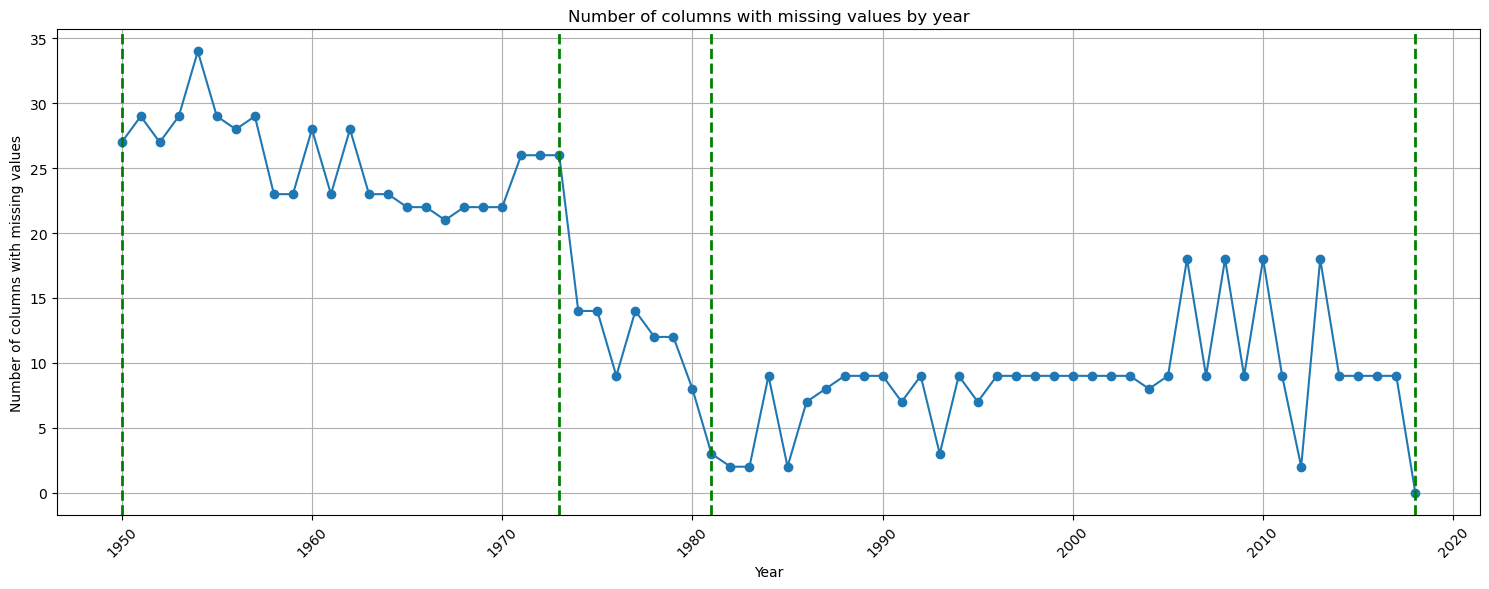

In [41]:
years = list(missing_values_per_year.keys())
missing_values = list(missing_values_per_year.values())

plt.figure(figsize=(15, 6))
plt.plot(years, missing_values, marker='o')
plt.title('Number of columns with missing values by year')
plt.xlabel('Year')
plt.ylabel('Number of columns with missing values')
plt.grid(True)
plt.xticks(rotation=45)

plt.axvline(x=1973, color='green', linestyle='--', linewidth=2)
plt.axvline(x=1981, color='green', linestyle='--', linewidth=2)
plt.axvline(x=1950, color='green', linestyle='--', linewidth=2)
plt.axvline(x=2018, color='green', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()


We'll make three reasonable groups.

The first group will be the most recent data, which is the most complete.

In [42]:
concat = [yearly_data[year] for year in range(1982, 2017)]
data3 = pd.concat(concat)
data3

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
1577,1982.0,2,24.0,0.931034,0.987952,0.709943,0.494310,0.493838,0.028,0.038000,...,0.131413,0.102839,0.237113,0.428571,0.026316,0.310345,0.411917,0.385207,0.535211,90.0
3624,1982.0,4,36.0,0.931034,0.987952,0.781041,0.477924,0.451585,0.005,0.064000,...,0.432043,0.347604,0.123711,0.205980,0.228070,0.448276,0.743523,0.327128,0.647887,106.0
3776,1982.0,4,22.0,0.666667,0.265060,0.276404,0.479745,0.497359,0.000,0.053500,...,0.195320,0.143322,0.032646,0.149502,0.166667,0.137931,0.404145,0.088608,0.422535,81.0
3794,1982.0,5,34.0,0.862069,0.915663,0.689593,0.518889,0.535211,0.002,0.056667,...,0.438344,0.306654,0.193299,0.209302,0.453947,0.495690,0.580311,0.451229,0.816901,102.0
3853,1982.0,3,34.0,0.114943,0.000000,0.044822,0.436049,0.366197,0.000,0.051500,...,0.011701,0.007911,0.011168,0.016611,0.004386,0.023707,0.064767,0.012906,0.535211,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24511,2016.0,4,23.0,0.103448,0.000000,0.017517,0.508421,0.423415,0.000,0.097167,...,0.021602,0.017683,0.004296,0.013289,0.010965,0.012931,0.038860,0.007198,0.535211,90.0
24513,2016.0,3,19.0,0.885057,0.096386,0.574961,0.450614,0.430458,0.251,0.042167,...,0.289829,0.187529,0.100515,0.225914,0.057018,0.204741,0.476684,0.124597,0.577465,102.0
24515,2016.0,4,20.0,0.183908,0.000000,0.037352,0.487028,0.431338,0.208,0.066000,...,0.022502,0.017683,0.002577,0.016611,0.015351,0.004310,0.028497,0.015140,0.718310,99.0
24517,2016.0,1,23.0,0.298851,0.012048,0.058990,0.493400,0.475352,0.163,0.073000,...,0.026103,0.017217,0.026632,0.026578,0.006579,0.034483,0.018135,0.025565,0.507042,83.0


Now we'll clean the three datasets individually.

We remove the unnecessary incomplete columns and discard the elements from the useful incomplete columns, similar to what we did with dataP, to strike a balance in order to retain as much information as possible.

In [43]:
print(data3.isnull().sum())

Year         0
Pos          0
Age          0
G            0
GS           0
MP           0
PER          5
TS%         74
3PAr        85
FTr         85
ORB%         5
DRB%         5
TRB%         5
AST%         5
STL%         5
BLK%         5
TOV%        59
USG%         5
OWS          0
DWS          0
WS           0
WS/48        5
OBPM         0
DBPM         0
BPM          0
VORP         0
FG           0
FGA          0
FG%         85
3P           0
3PA          0
3P%       3292
2P           0
2PA          0
2P%        111
eFG%        85
FT           0
FTA          0
FT%        703
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
height       0
weight       0
dtype: int64


Here, we notice that there's a significant amount of missing data for 3p%, but for the others, we can afford to just remove the rows with missing values.

We will repeat this process for the three datasets (without adding comments).

In [44]:
data3 = data3.drop(['3P%'], axis=1)
data3 = data3.dropna()
data3

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
1577,1982.0,2,24.0,0.931034,0.987952,0.709943,0.494310,0.493838,0.028,0.038000,...,0.131413,0.102839,0.237113,0.428571,0.026316,0.310345,0.411917,0.385207,0.535211,90.0
3624,1982.0,4,36.0,0.931034,0.987952,0.781041,0.477924,0.451585,0.005,0.064000,...,0.432043,0.347604,0.123711,0.205980,0.228070,0.448276,0.743523,0.327128,0.647887,106.0
3776,1982.0,4,22.0,0.666667,0.265060,0.276404,0.479745,0.497359,0.000,0.053500,...,0.195320,0.143322,0.032646,0.149502,0.166667,0.137931,0.404145,0.088608,0.422535,81.0
3794,1982.0,5,34.0,0.862069,0.915663,0.689593,0.518889,0.535211,0.002,0.056667,...,0.438344,0.306654,0.193299,0.209302,0.453947,0.495690,0.580311,0.451229,0.816901,102.0
3853,1982.0,3,34.0,0.114943,0.000000,0.044822,0.436049,0.366197,0.000,0.051500,...,0.011701,0.007911,0.011168,0.016611,0.004386,0.023707,0.064767,0.012906,0.535211,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24511,2016.0,4,23.0,0.103448,0.000000,0.017517,0.508421,0.423415,0.000,0.097167,...,0.021602,0.017683,0.004296,0.013289,0.010965,0.012931,0.038860,0.007198,0.535211,90.0
24513,2016.0,3,19.0,0.885057,0.096386,0.574961,0.450614,0.430458,0.251,0.042167,...,0.289829,0.187529,0.100515,0.225914,0.057018,0.204741,0.476684,0.124597,0.577465,102.0
24515,2016.0,4,20.0,0.183908,0.000000,0.037352,0.487028,0.431338,0.208,0.066000,...,0.022502,0.017683,0.002577,0.016611,0.015351,0.004310,0.028497,0.015140,0.718310,99.0
24517,2016.0,1,23.0,0.298851,0.012048,0.058990,0.493400,0.475352,0.163,0.073000,...,0.026103,0.017217,0.026632,0.026578,0.006579,0.034483,0.018135,0.025565,0.507042,83.0


In [45]:
concat = [yearly_data[year] for year in range(1974, 1981)]
data2 = pd.concat(concat)
data2

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
1898,1974.0,2,37.0,0.045977,NaN,0.014941,0.455166,0.354754,NaN,0.019167,...,0.002700,0.001861,0.005155,0.003322,0.000000,NaN,0.005181,0.005460,0.464789,86.0
2105,1974.0,1,35.0,0.793103,NaN,0.638073,0.477014,0.441901,NaN,0.054833,...,0.187219,0.129828,0.383162,0.255814,0.008772,NaN,0.341969,0.220402,0.507042,92.0
2132,1974.0,1,35.0,0.344828,NaN,0.249098,0.514338,0.456866,NaN,0.063667,...,0.077408,0.053979,0.176976,0.269103,0.050439,NaN,0.207254,0.156118,0.394366,79.0
2146,1974.0,1,36.0,0.839080,NaN,0.639619,0.497497,0.463028,NaN,0.060500,...,0.177318,0.128897,0.448454,0.322259,0.037281,NaN,0.427461,0.301067,0.352113,81.0
2167,1974.0,5,34.0,0.873563,NaN,0.628542,0.481566,0.458627,NaN,0.079667,...,0.428443,0.344346,0.162371,0.172757,0.105263,NaN,0.601036,0.250931,0.718310,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1980.0,4,23.0,0.252874,NaN,0.031942,0.452890,0.353873,0.109,0.026000,...,0.019802,0.015821,0.010309,0.013289,0.010965,0.034483,0.051813,0.013651,0.647887,95.0
7557,1980.0,1,23.0,0.873563,NaN,0.462133,0.451525,0.408451,0.023,0.019333,...,0.076508,0.049325,0.157216,0.332226,0.024123,0.230603,0.430052,0.125589,0.394366,81.0
7558,1980.0,3,22.0,0.643678,NaN,0.143225,0.461083,0.382042,0.015,0.056167,...,0.050405,0.056305,0.030928,0.063123,0.017544,0.105603,0.189119,0.066021,0.577465,95.0
7565,1980.0,2,24.0,0.172414,NaN,0.036837,0.421939,0.271127,0.000,0.040000,...,0.009001,0.007445,0.010309,0.006645,0.000000,0.017241,0.028497,0.004219,0.422535,79.0


In [46]:
print(data2.isnull().sum())

Year         0
Pos          0
Age          0
G            0
GS        2214
MP           0
PER          0
TS%          6
3PAr      1871
FTr          7
ORB%         0
DRB%         0
TRB%         0
AST%         0
STL%         0
BLK%         0
TOV%      1154
USG%      1152
OWS          0
DWS          0
WS           0
WS/48        0
OBPM         0
DBPM         0
BPM          0
VORP         0
FG           0
FGA          0
FG%          7
3P        1870
3PA       1870
3P%       1954
2P           0
2PA          0
2P%          7
eFG%         7
FT           0
FTA          0
FT%         50
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV       1152
PF           0
PTS          0
height       0
weight       0
dtype: int64


In [47]:
data2 = data2.drop(['3P%','TOV','3P','3PA','GS','3PAr','TOV%','USG%',], axis=1)
data2 = data2.dropna()
data2

,Year,Pos,Age,G,MP,PER,TS%,FTr,ORB%,DRB%,...,ORB,DRB,TRB,AST,STL,BLK,PF,PTS,height,weight
1898,1974.0,2,37.0,0.045977,0.014941,0.455166,0.354754,0.019167,0.018,0.054,...,0.001704,0.002700,0.001861,0.005155,0.003322,0.000000,0.005181,0.005460,0.464789,86.0
2105,1974.0,1,35.0,0.793103,0.638073,0.477014,0.441901,0.054833,0.031,0.080,...,0.120954,0.187219,0.129828,0.383162,0.255814,0.008772,0.341969,0.220402,0.507042,92.0
2132,1974.0,1,35.0,0.344828,0.249098,0.514338,0.456866,0.063667,0.030,0.078,...,0.051107,0.077408,0.053979,0.176976,0.269103,0.050439,0.207254,0.156118,0.394366,79.0
2146,1974.0,1,36.0,0.839080,0.639619,0.497497,0.463028,0.060500,0.031,0.086,...,0.136286,0.177318,0.128897,0.448454,0.322259,0.037281,0.427461,0.301067,0.352113,81.0
2167,1974.0,5,34.0,0.873563,0.628542,0.481566,0.458627,0.079667,0.107,0.200,...,0.449744,0.428443,0.344346,0.162371,0.172757,0.105263,0.601036,0.250931,0.718310,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1980.0,4,23.0,0.252874,0.031942,0.452890,0.353873,0.026000,0.109,0.178,...,0.020443,0.019802,0.015821,0.010309,0.013289,0.010965,0.051813,0.013651,0.647887,95.0
7557,1980.0,1,23.0,0.873563,0.462133,0.451525,0.408451,0.019333,0.014,0.053,...,0.035775,0.076508,0.049325,0.157216,0.332226,0.024123,0.430052,0.125589,0.394366,81.0
7558,1980.0,3,22.0,0.643678,0.143225,0.461083,0.382042,0.056167,0.126,0.111,...,0.110733,0.050405,0.056305,0.030928,0.063123,0.017544,0.189119,0.066021,0.577465,95.0
7565,1980.0,2,24.0,0.172414,0.036837,0.421939,0.271127,0.040000,0.045,0.080,...,0.010221,0.009001,0.007445,0.010309,0.006645,0.000000,0.028497,0.004219,0.422535,79.0


In [48]:
concat = [yearly_data[year] for year in range(1950, 1973)]
data1 = pd.concat(concat)
data1

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,1950.0,2,31.0,0.712644,NaN,NaN,NaN,0.323944,NaN,0.077833,...,NaN,NaN,0.151203,NaN,NaN,NaN,0.562176,0.113676,0.281690,77.0
2,1950.0,2,29.0,0.551724,NaN,NaN,NaN,0.382923,NaN,0.064500,...,NaN,NaN,0.093643,NaN,NaN,NaN,0.256477,0.069248,0.394366,83.0
5,1950.0,3,25.0,0.758621,NaN,NaN,NaN,0.346831,NaN,0.043167,...,NaN,NaN,0.120275,NaN,NaN,NaN,0.497409,0.108712,0.464789,86.0
10,1950.0,3,24.0,0.160920,NaN,NaN,NaN,0.274648,NaN,0.065833,...,NaN,NaN,0.017182,NaN,NaN,NaN,0.075130,0.015637,0.507042,88.0
11,1950.0,3,24.0,0.137931,NaN,NaN,NaN,0.271127,NaN,0.063000,...,NaN,NaN,0.017182,NaN,NaN,NaN,0.069948,0.014644,0.507042,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,1972.0,2,21.0,0.919540,NaN,0.559763,0.463359,0.405810,NaN,0.029667,...,NaN,0.173104,0.149485,NaN,NaN,NaN,0.777202,0.239017,0.507042,97.0
4606,1972.0,2,23.0,0.540230,NaN,0.082947,0.469731,0.364437,NaN,0.052667,...,NaN,0.021871,0.035223,NaN,NaN,NaN,0.082902,0.041449,0.394366,79.0
4607,1972.0,1,22.0,0.896552,NaN,0.419371,0.462904,0.429577,NaN,0.060500,...,NaN,0.069800,0.195876,NaN,NaN,NaN,0.593264,0.159345,0.394366,83.0
4620,1972.0,4,26.0,0.264368,NaN,0.037094,0.461083,0.345951,NaN,0.022167,...,NaN,0.018613,0.006014,NaN,NaN,NaN,0.036269,0.017126,0.577465,97.0


In [49]:
print(data1.isnull().sum())

Year         0
Pos          0
Age          8
G            0
GS        3558
MP         486
PER        518
TS%          3
3PAr      3558
FTr          3
ORB%      3558
DRB%      3558
TRB%      3048
AST%      2064
STL%      3558
BLK%      3558
TOV%      3558
USG%      3558
OWS         39
DWS         39
WS          39
WS/48      518
OBPM      3558
DBPM      3558
BPM       3558
VORP      3558
FG           0
FGA          0
FG%          3
3P        3558
3PA       3558
3P%       3558
2P           0
2PA          0
2P%          3
eFG%         3
FT           0
FTA          0
FT%         56
ORB       3558
DRB       3558
TRB        312
AST          0
STL       3558
BLK       3558
TOV       3558
PF           0
PTS          0
height       0
weight       0
dtype: int64


In [50]:
data1 = data1.drop(['3P%','TOV','3P','3PA','GS','3PAr','TOV%','USG%','STL','BLK','TOV','ORB','DRB','TRB','MP','PER','BLK%','STL%','AST%','TRB%','DRB%','ORB%','WS/48','OBPM','DBPM','BPM','VORP'], axis=1)
data1 = data1.dropna()
data1

,Year,Pos,Age,G,TS%,FTr,OWS,DWS,WS,FG,...,2P%,eFG%,FT,FTA,FT%,AST,PF,PTS,height,weight
0,1950.0,2,31.0,0.712644,0.323944,0.077833,0.213675,0.270588,0.223404,0.090169,...,0.279,0.186000,0.202381,0.176816,0.705,0.151203,0.562176,0.113676,0.281690,77.0
2,1950.0,2,29.0,0.551724,0.382923,0.064500,0.286325,0.094118,0.177305,0.063870,...,0.372,0.248000,0.089286,0.077770,0.708,0.093643,0.256477,0.069248,0.394366,83.0
5,1950.0,3,25.0,0.758621,0.346831,0.043167,0.256410,0.223529,0.226950,0.108954,...,0.349,0.232667,0.107143,0.094644,0.698,0.120275,0.497409,0.108712,0.464789,86.0
10,1950.0,3,24.0,0.160920,0.274648,0.065833,0.196581,0.052941,0.078014,0.013776,...,0.256,0.170667,0.022619,0.024945,0.559,0.017182,0.075130,0.015637,0.507042,88.0
11,1950.0,3,24.0,0.137931,0.271127,0.063000,0.196581,0.052941,0.078014,0.013150,...,0.256,0.170667,0.020238,0.022744,0.548,0.017182,0.069948,0.014644,0.507042,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,1972.0,2,21.0,0.919540,0.405810,0.029667,0.209402,0.100000,0.113475,0.261741,...,0.432,0.288000,0.151190,0.126192,0.738,0.149485,0.777202,0.239017,0.507042,97.0
4606,1972.0,2,23.0,0.540230,0.364437,0.052667,0.196581,0.064706,0.081560,0.039449,...,0.356,0.237333,0.048810,0.041086,0.732,0.035223,0.082902,0.041449,0.394366,79.0
4607,1972.0,1,22.0,0.896552,0.429577,0.060500,0.260684,0.129412,0.173759,0.152160,...,0.429,0.286000,0.185714,0.151137,0.757,0.195876,0.593264,0.159345,0.394366,83.0
4620,1972.0,4,26.0,0.264368,0.345951,0.022167,0.200855,0.064706,0.092199,0.019411,...,0.373,0.248667,0.008333,0.008070,0.636,0.006014,0.036269,0.017126,0.577465,97.0


Now that our datasets are cleaned, we can move on to visualizations to prepare for machine learning.

**Vizualisations:**

Let's create correlation matrix to identify the most correlated values. We will focus particularly on the "Pos" row to see which values have the most influence on the player's position.

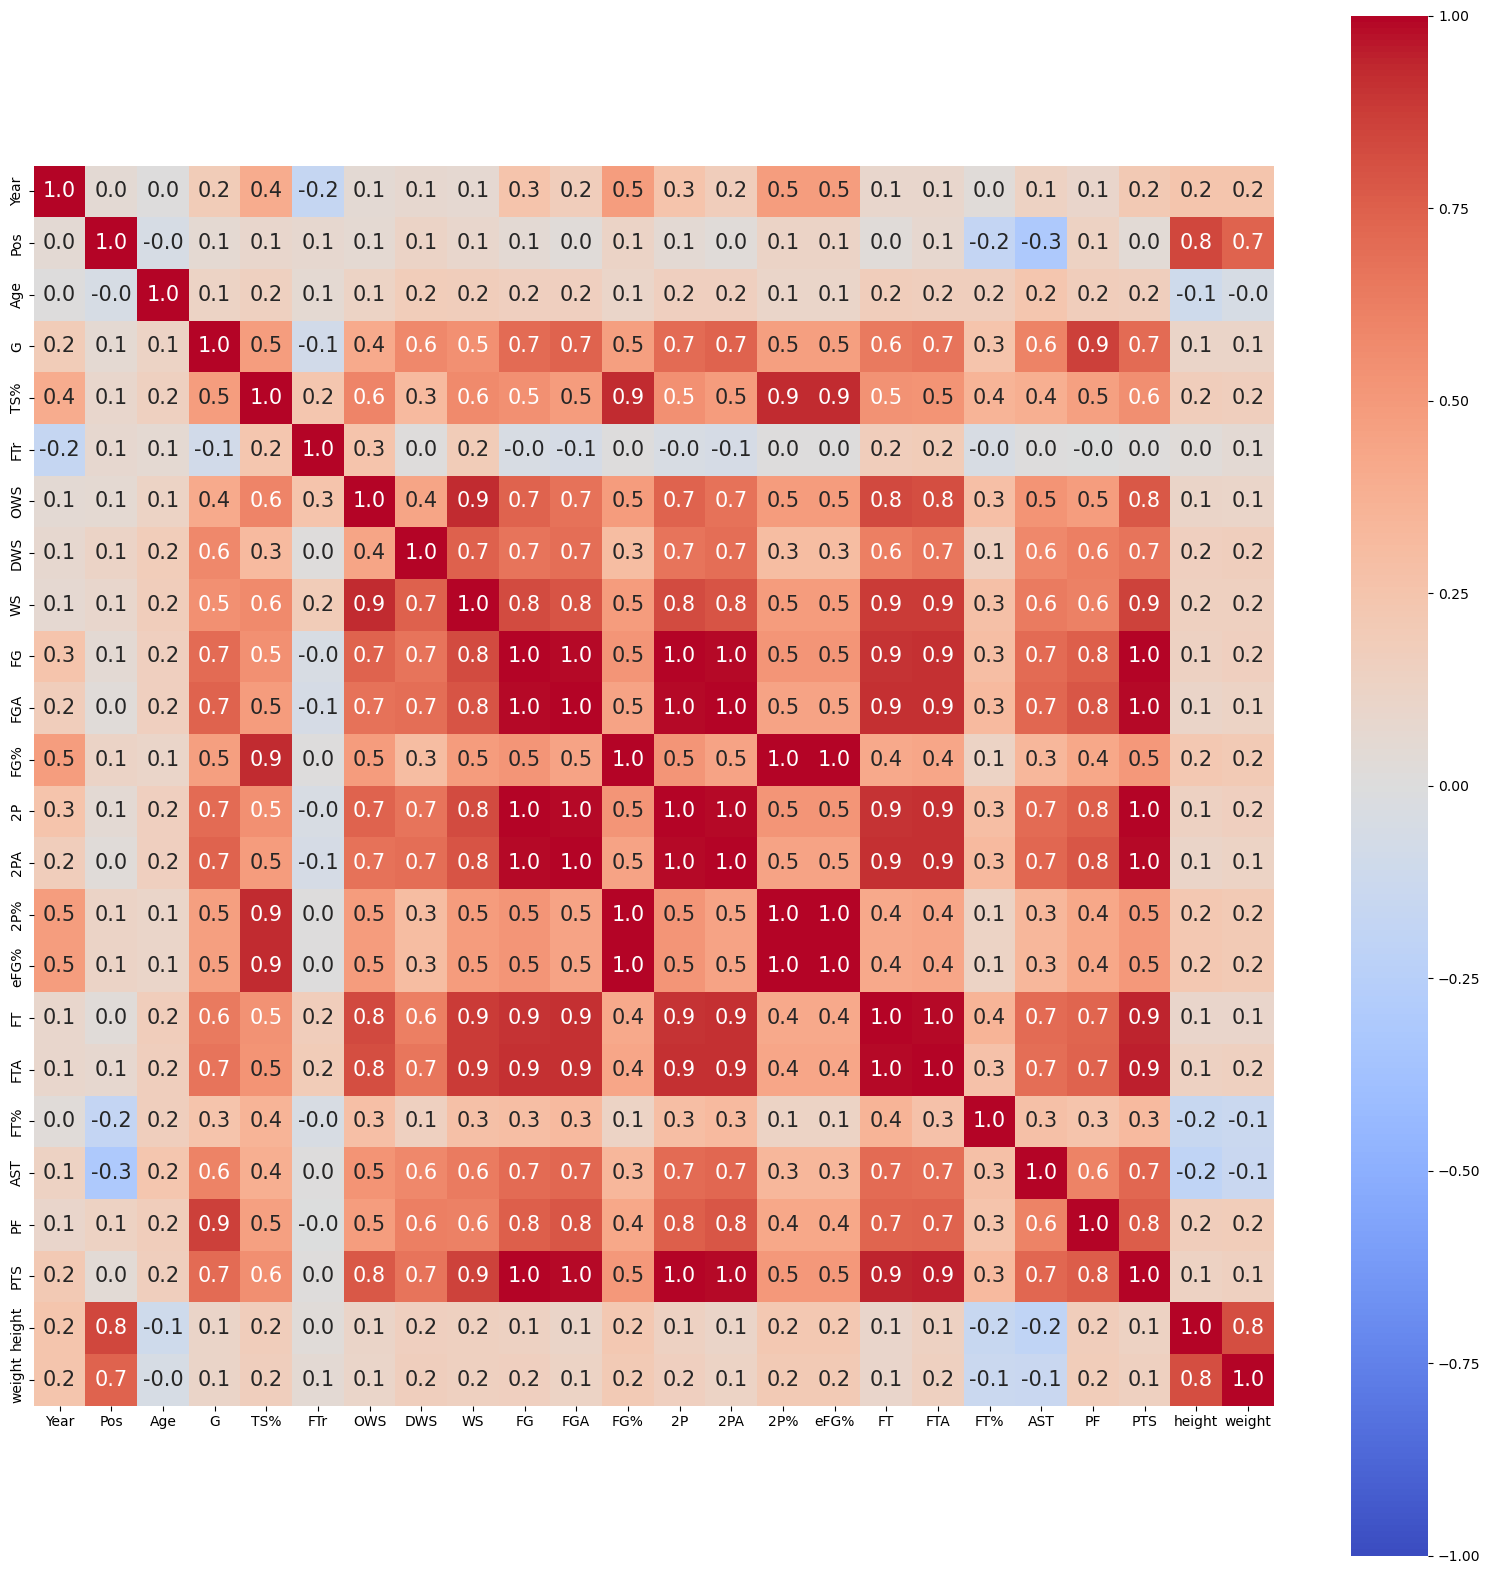

In [51]:
corr1 = data1.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr1, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()

We notice that for the older values, "Pos" is hardly correlated with anything, which means we might have difficulty utilizing these data effectively.

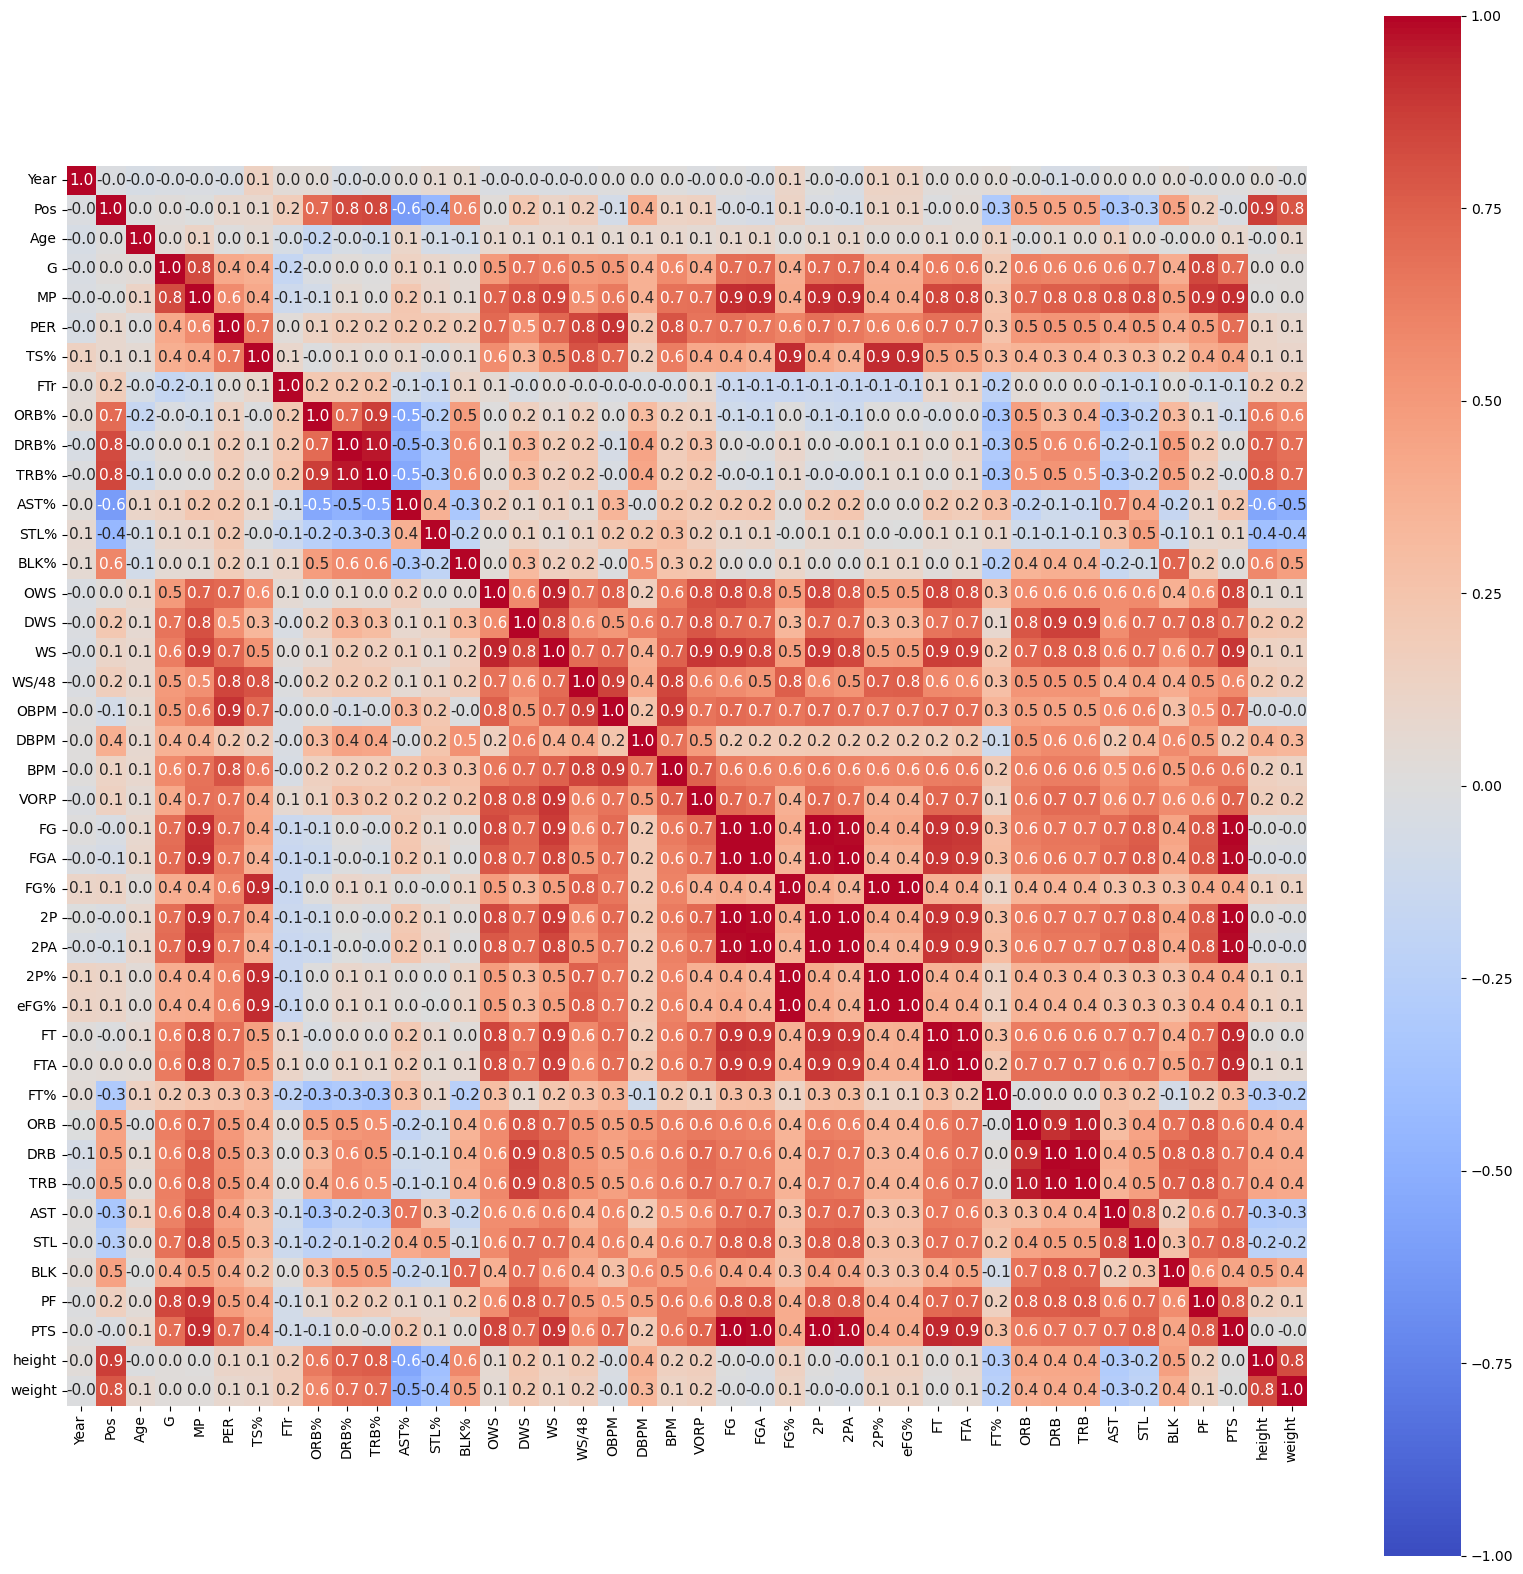

In [52]:
corr2 = data2.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr2, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':11}, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()

It's much better now, there are many correlated data points.

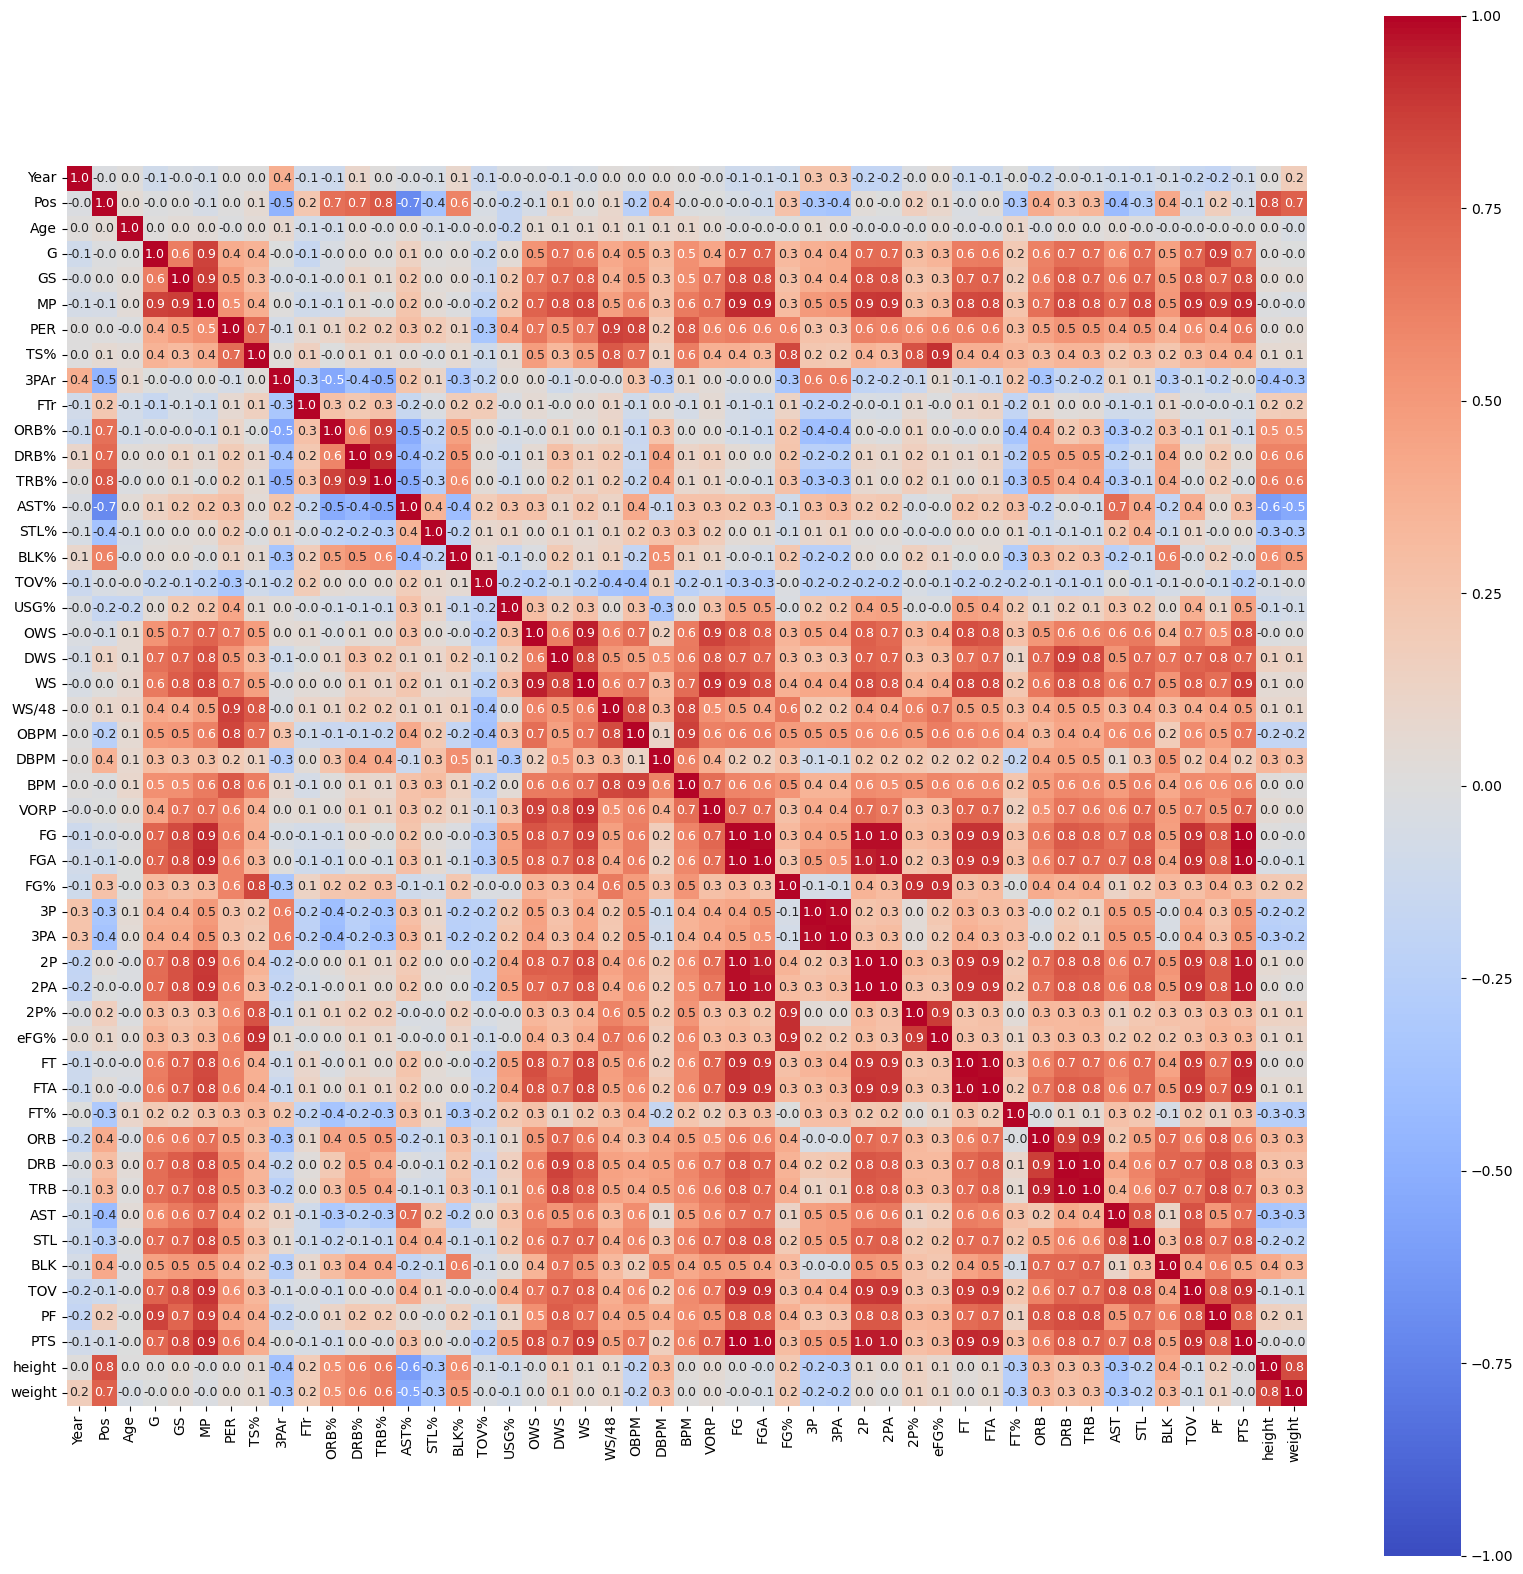

In [53]:
corr3 = data3.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr3, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':9}, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()

We notice that data2 and data3 are similar, with little relevant addition between data3 and data2. However, data1 has less data, indicating that analyzing data prior to 1974 will be challenging.

However, to compare on an equal footing, we will need to create datasets that are:

- OF THE SAME SIZE
- WITH THE SAME NUMBER OF COLUMNS

It's clear that we won't use data prior to 1974 as there aren't enough correlated columns.

Here's what we've decided to do:

Create an "old" dataset and a "modern" dataset, both of the same size and with the same number of columns.

We'll choose a size that is large enough but not too large to avoid excessive similarity between the datasets.

In [54]:
concat = [yearly_data[year] for year in range(1974, 1986)]
data_old = pd.concat(concat)
data_old

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
1898,1974.0,2,37.0,0.045977,NaN,0.014941,0.455166,0.354754,NaN,0.019167,...,0.002700,0.001861,0.005155,0.003322,0.000000,NaN,0.005181,0.005460,0.464789,86.0
2105,1974.0,1,35.0,0.793103,NaN,0.638073,0.477014,0.441901,NaN,0.054833,...,0.187219,0.129828,0.383162,0.255814,0.008772,NaN,0.341969,0.220402,0.507042,92.0
2132,1974.0,1,35.0,0.344828,NaN,0.249098,0.514338,0.456866,NaN,0.063667,...,0.077408,0.053979,0.176976,0.269103,0.050439,NaN,0.207254,0.156118,0.394366,79.0
2146,1974.0,1,36.0,0.839080,NaN,0.639619,0.497497,0.463028,NaN,0.060500,...,0.177318,0.128897,0.448454,0.322259,0.037281,NaN,0.427461,0.301067,0.352113,81.0
2167,1974.0,5,34.0,0.873563,NaN,0.628542,0.481566,0.458627,NaN,0.079667,...,0.428443,0.344346,0.162371,0.172757,0.105263,NaN,0.601036,0.250931,0.718310,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,1985.0,4,22.0,0.931034,0.228916,0.459815,0.471097,0.437500,0.013,0.043667,...,0.310531,0.242904,0.030928,0.102990,0.107456,0.224138,0.585492,0.189873,0.394366,79.0
9822,1985.0,1,23.0,0.839080,0.277108,0.324575,0.461538,0.441021,0.055,0.043500,...,0.086409,0.060959,0.186426,0.255814,0.026316,0.204741,0.316062,0.080665,0.323944,86.0
9824,1985.0,1,22.0,0.425287,0.012048,0.069294,0.453801,0.368838,0.224,0.032333,...,0.013501,0.008376,0.038660,0.026578,0.000000,0.053879,0.044041,0.030280,0.422535,83.0
9834,1985.0,1,22.0,0.022989,0.000000,0.006698,0.414656,0.176056,0.100,0.000000,...,0.002700,0.001396,0.001718,0.009967,0.000000,0.004310,0.005181,0.000993,0.422535,79.0


In [55]:
data_old = data_old.drop(['3P%','TOV','3P','3PA','GS','3PAr','TOV%','USG%',], axis=1)
data_old = data_old.dropna()
data_old

,Year,Pos,Age,G,MP,PER,TS%,FTr,ORB%,DRB%,...,ORB,DRB,TRB,AST,STL,BLK,PF,PTS,height,weight
1898,1974.0,2,37.0,0.045977,0.014941,0.455166,0.354754,0.019167,0.018,0.054,...,0.001704,0.002700,0.001861,0.005155,0.003322,0.000000,0.005181,0.005460,0.464789,86.0
2105,1974.0,1,35.0,0.793103,0.638073,0.477014,0.441901,0.054833,0.031,0.080,...,0.120954,0.187219,0.129828,0.383162,0.255814,0.008772,0.341969,0.220402,0.507042,92.0
2132,1974.0,1,35.0,0.344828,0.249098,0.514338,0.456866,0.063667,0.030,0.078,...,0.051107,0.077408,0.053979,0.176976,0.269103,0.050439,0.207254,0.156118,0.394366,79.0
2146,1974.0,1,36.0,0.839080,0.639619,0.497497,0.463028,0.060500,0.031,0.086,...,0.136286,0.177318,0.128897,0.448454,0.322259,0.037281,0.427461,0.301067,0.352113,81.0
2167,1974.0,5,34.0,0.873563,0.628542,0.481566,0.458627,0.079667,0.107,0.200,...,0.449744,0.428443,0.344346,0.162371,0.172757,0.105263,0.601036,0.250931,0.718310,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,1985.0,3,24.0,0.103448,0.009789,0.414656,0.360915,0.083333,0.030,0.056,...,0.001704,0.001800,0.001396,0.001718,0.000000,0.000000,0.020725,0.003475,0.676056,99.0
9793,1985.0,3,24.0,0.229885,0.030654,0.479290,0.411972,0.013167,0.136,0.114,...,0.025554,0.010801,0.012564,0.007732,0.016611,0.004386,0.044041,0.015140,0.394366,79.0
9795,1985.0,4,22.0,0.931034,0.459815,0.471097,0.437500,0.043667,0.110,0.209,...,0.301533,0.310531,0.242904,0.030928,0.102990,0.107456,0.585492,0.189873,0.394366,79.0
9822,1985.0,1,23.0,0.839080,0.324575,0.461538,0.441021,0.043500,0.029,0.093,...,0.059625,0.086409,0.060959,0.186426,0.255814,0.026316,0.316062,0.080665,0.323944,86.0


In [56]:
concat = [yearly_data[year] for year in range(2010, 2017)]
data_modern = pd.concat(concat)
data_modern

,Year,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
5825,2010.0,3,29.0,0.758621,0.180723,0.382792,0.472007,0.467430,0.423,0.047167,...,0.189919,0.109819,0.088488,0.126246,0.032895,0.155172,0.272021,0.165302,0.422535,81.0
7366,2010.0,2,22.0,0.482759,0.000000,0.091448,0.456532,0.398768,0.183,0.075333,...,0.036004,0.025593,0.011168,0.033223,0.019737,0.030172,0.064767,0.028047,0.394366,79.0
11154,2010.0,3,23.0,0.264368,0.120482,0.201443,0.485662,0.517606,0.325,0.036500,...,0.082808,0.051187,0.056701,0.076412,0.013158,0.062500,0.126943,0.090593,0.577465,86.0
13738,2010.0,5,37.0,0.597701,0.638554,0.319423,0.493855,0.497359,0.002,0.081333,...,0.235824,0.165193,0.068729,0.049834,0.135965,0.226293,0.437824,0.157856,0.788732,147.0
14174,2010.0,1,39.0,0.137931,0.000000,0.031427,0.402367,0.184859,0.433,0.011167,...,0.011701,0.006515,0.007732,0.003322,0.000000,0.008621,0.031088,0.003227,0.394366,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24511,2016.0,4,23.0,0.103448,0.000000,0.017517,0.508421,0.423415,0.000,0.097167,...,0.021602,0.017683,0.004296,0.013289,0.010965,0.012931,0.038860,0.007198,0.535211,90.0
24513,2016.0,3,19.0,0.885057,0.096386,0.574961,0.450614,0.430458,0.251,0.042167,...,0.289829,0.187529,0.100515,0.225914,0.057018,0.204741,0.476684,0.124597,0.577465,102.0
24515,2016.0,4,20.0,0.183908,0.000000,0.037352,0.487028,0.431338,0.208,0.066000,...,0.022502,0.017683,0.002577,0.016611,0.015351,0.004310,0.028497,0.015140,0.718310,99.0
24517,2016.0,1,23.0,0.298851,0.012048,0.058990,0.493400,0.475352,0.163,0.073000,...,0.026103,0.017217,0.026632,0.026578,0.006579,0.034483,0.018135,0.025565,0.507042,83.0


In [57]:
data_modern = data_modern.drop(['3P%','TOV','3P','3PA','GS','3PAr','TOV%','USG%',], axis=1)
data_modern = data_modern.dropna()
data_modern

,Year,Pos,Age,G,MP,PER,TS%,FTr,ORB%,DRB%,...,ORB,DRB,TRB,AST,STL,BLK,PF,PTS,height,weight
5825,2010.0,3,29.0,0.758621,0.382792,0.472007,0.467430,0.047167,0.018,0.156,...,0.042589,0.189919,0.109819,0.088488,0.126246,0.032895,0.272021,0.165302,0.422535,81.0
7366,2010.0,2,22.0,0.482759,0.091448,0.456532,0.398768,0.075333,0.052,0.133,...,0.025554,0.036004,0.025593,0.011168,0.033223,0.019737,0.064767,0.028047,0.394366,79.0
11154,2010.0,3,23.0,0.264368,0.201443,0.485662,0.517606,0.036500,0.025,0.133,...,0.030664,0.082808,0.051187,0.056701,0.076412,0.013158,0.126943,0.090593,0.577465,86.0
13738,2010.0,5,37.0,0.597701,0.319423,0.493855,0.497359,0.081333,0.094,0.240,...,0.158433,0.235824,0.165193,0.068729,0.049834,0.135965,0.437824,0.157856,0.788732,147.0
14174,2010.0,1,39.0,0.137931,0.031427,0.402367,0.184859,0.011167,0.009,0.117,...,0.001704,0.011701,0.006515,0.007732,0.003322,0.000000,0.031088,0.003227,0.394366,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24511,2016.0,4,23.0,0.103448,0.017517,0.508421,0.423415,0.097167,0.219,0.392,...,0.023850,0.021602,0.017683,0.004296,0.013289,0.010965,0.038860,0.007198,0.535211,90.0
24513,2016.0,3,19.0,0.885057,0.574961,0.450614,0.430458,0.042167,0.042,0.158,...,0.137990,0.289829,0.187529,0.100515,0.225914,0.057018,0.476684,0.124597,0.577465,102.0
24515,2016.0,4,20.0,0.183908,0.037352,0.487028,0.431338,0.066000,0.094,0.194,...,0.022147,0.022502,0.017683,0.002577,0.016611,0.015351,0.028497,0.015140,0.718310,99.0
24517,2016.0,1,23.0,0.298851,0.058990,0.493400,0.475352,0.073000,0.041,0.143,...,0.013629,0.026103,0.017217,0.026632,0.026578,0.006579,0.018135,0.025565,0.507042,83.0


Here is a summary of all the pre-processing done in terms of datasets modifications:

https://ibb.co/zZvX3Vn

Let's do some visualizations with the data that we saw to have a high correlation rate with "Pos".

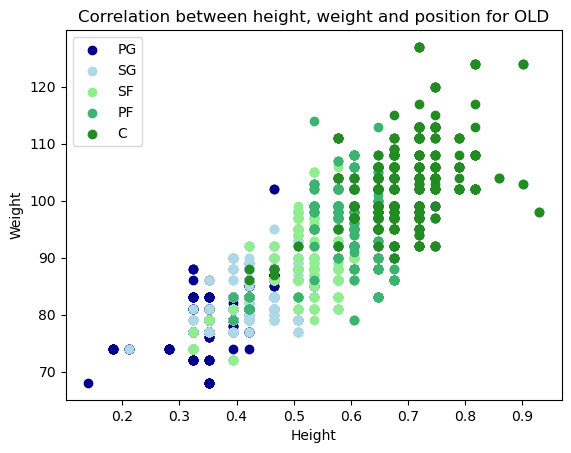

In [83]:
x = data_old['height']
y = data_old['weight']
z = data_old['Pos']
legend_dict = {1: 'PG', 2: 'SG', 3: 'SF', 4: 'PF', 5: 'C'}
colors = [ 'darkblue','lightblue', 'lightgreen', 'mediumseagreen', 'forestgreen']

for i in range(1, 6):
    plt.scatter(x[z == i], y[z == i], color=colors[i-1], label=legend_dict[i])

plt.legend()
plt.title('Correlation between height, weight and position for OLD')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

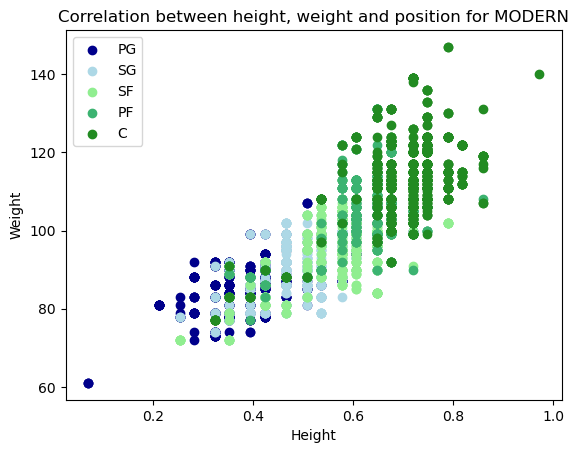

In [84]:
x = data_modern['height']
y = data_modern['weight']
z = data_modern['Pos']
legend_dict = {1: 'PG', 2: 'SG', 3: 'SF', 4: 'PF', 5: 'C'}
colors = [ 'darkblue','lightblue', 'lightgreen', 'mediumseagreen', 'forestgreen']

for i in range(1, 6):
    plt.scatter(x[z == i], y[z == i], color=colors[i-1], label=legend_dict[i])

plt.legend()
plt.title('Correlation between height, weight and position for MODERN')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

Here, we notice that the distribution of height/weight is more homogeneous in data_modern.

There are far fewer "small, frail players" or "tall, heavy players". All players appear to be "in shape" and have an optimal weight with the advancement of medicine. This gives us a hint that distinguishing players will likely be more challenging.

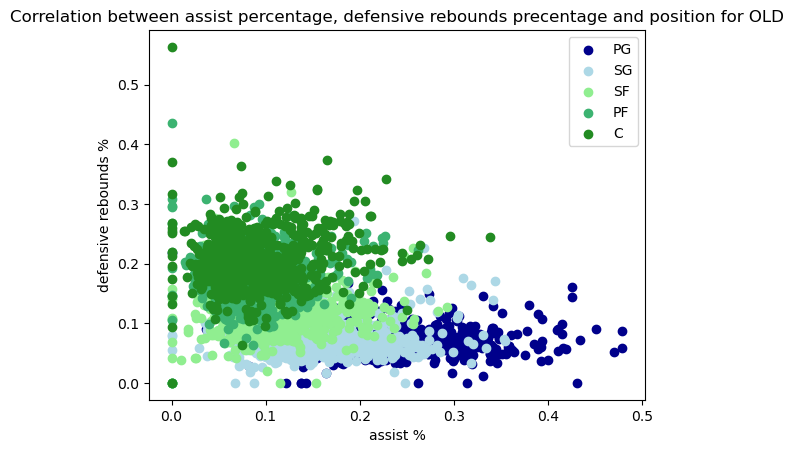

In [85]:
x = data_old['AST%']
y = data_old['DRB%']
z = data_old['Pos']
legend_dict = {1: 'PG', 2: 'SG', 3: 'SF', 4: 'PF', 5: 'C'}
colors = [ 'darkblue','lightblue', 'lightgreen', 'mediumseagreen', 'forestgreen']

for i in range(1, 6):
    plt.scatter(x[z == i], y[z == i], color=colors[i-1], label=legend_dict[i])

plt.legend()
plt.title('Correlation between assist percentage, defensive rebounds precentage and position for OLD')
plt.xlabel('assist %')
plt.ylabel('defensive rebounds %')
plt.show()

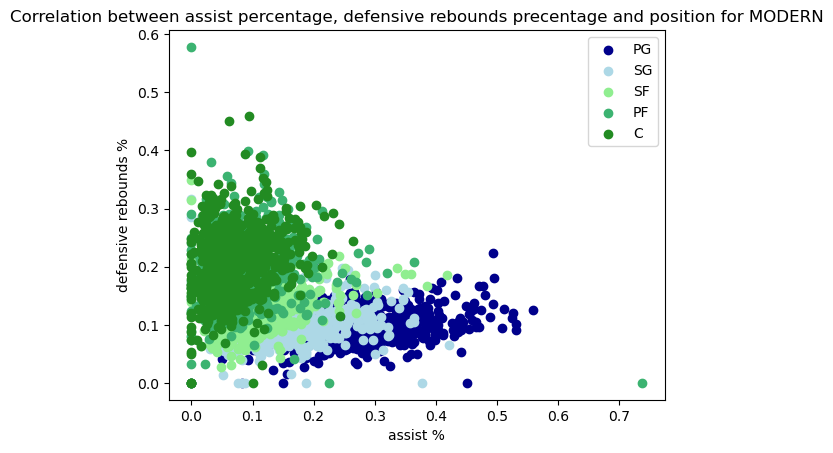

In [86]:
x = data_modern['AST%']
y = data_modern['DRB%']
z = data_modern['Pos']
legend_dict = {1: 'PG', 2: 'SG', 3: 'SF', 4: 'PF', 5: 'C'}
colors = [ 'darkblue','lightblue', 'lightgreen', 'mediumseagreen', 'forestgreen']

for i in range(1, 6):
    plt.scatter(x[z == i], y[z == i], color=colors[i-1], label=legend_dict[i])

plt.legend()
plt.title('Correlation between assist percentage, defensive rebounds precentage and position for MODERN')
plt.xlabel('assist %')
plt.ylabel('defensive rebounds %')
plt.show()

Here as well, it's more homogeneous. Players seem to be doing more and more "the same thing" on the court.

Players in the modern era seem to be more versatile, engaging in a wider range of activities during games. This versatility indicates that current players are less held into traditional roles (like solely being a scorer or rebounder)

**Machine-Learning**

First, we test them on one dataset to see if it has potential.

Since our dataset is large enough, there's no need for cross-validation. We want to see the train and test scores regardless.

In [62]:
X = data_old.drop('Pos', axis=1)
y = data_old['Pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## k-Nearest Neighbors 

In [63]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_train = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

In [64]:
print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)
#print(classification_report(y_test, y_pred))

Accuracy (train)= 0.6823492263972214
Accuracy = 0.5492424242424242


Mediocre, we're changing the algorithm.

## Gaussian Naive Bayes

In [65]:
nb = GaussianNB(var_smoothing=1e-09)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [66]:
print("Accuracy (train)=", accuracy_train)
print("Accuracy : ", accuracy)
#print(classification_report(y_test, y_pred))

Accuracy (train)= 0.6823492263972214
Accuracy :  0.6325757575757576


Same, disappointing results.

## Random forest

(Since this dataset has very good results, we'll work on it.)

First, let's start with "old."


In [67]:
X = data_old.drop('Pos', axis=1)
y = data_old['Pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Accuracy (train)= 1.0
Accuracy = 0.797979797979798
              precision    recall  f1-score   support

           1       0.83      0.80      0.81       147
           2       0.77      0.72      0.74       167
           3       0.77      0.87      0.81       184
           4       0.75      0.71      0.73       141
           5       0.90      0.87      0.88       153

    accuracy                           0.80       792
   macro avg       0.80      0.80      0.80       792
weighted avg       0.80      0.80      0.80       792

Matrice de confusion:


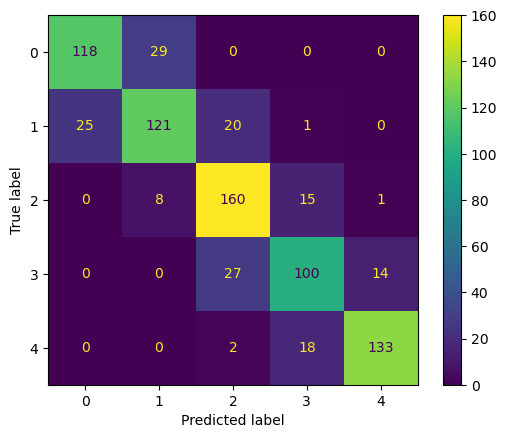

In [68]:
rf = RandomForestClassifier( #We're fixing the base parameters
    n_estimators=100, 
    max_depth=None,  
    random_state=1  
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_train = rf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)

print(classification_report(y_test, y_pred))

print("Matrice de confusion:")
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

We achieved a precision of 0.80, which was excellent. However, an accuracy precision of 1.0 indicated potential overfitting, a point that might need improvement.

The confusion matrix interestingly showed high accuracy in predicting players in the winger position, a surprising outcome given the versatility of this role and the era (1974-1986) not being particularly dominated by wingers.

In [69]:
X = data_modern.drop('Pos', axis=1)
y = data_modern['Pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Accuracy (train)= 1.0
Accuracy = 0.7603513174404015
              precision    recall  f1-score   support

           1       0.88      0.93      0.90       160
           2       0.72      0.68      0.70       164
           3       0.60      0.66      0.63       144
           4       0.77      0.72      0.74       174
           5       0.83      0.81      0.82       155

    accuracy                           0.76       797
   macro avg       0.76      0.76      0.76       797
weighted avg       0.76      0.76      0.76       797

Matrice de confusion:


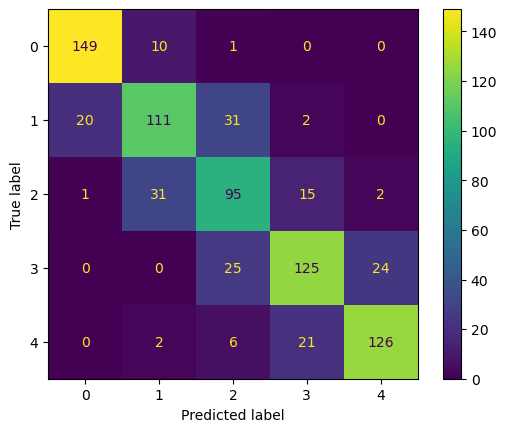

In [70]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,  
    random_state=1  
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_train = rf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)

print(classification_report(y_test, y_pred))

print("Matrice de confusion:")
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

The precision was slightly lower at 0.76, a noticeable difference from the older dataset. Despite changing the "random_state," we consistently found around a 4% difference.

A training precision of 1.0 again suggested overfitting.

The confusion matrix results were more explainable, with the algorithm accurately predicting "guards" positions. This aligns with the NBA dynamics from 2010-2017, a period dominated by guards who often play pivotal roles on the court.

**Search for hyperparameters:**

In terms of hyperparameter tuning, we decided to optimize them individually for each dataset. We chose to adjust hyperparameters one by one, avoiding grid search to prevent overfitting specific to training data and avoiding random search due to time constraints. We only had time to adjust four values across two hyperparameters, due to the lengthy computation time required by this algorithm. 

In [71]:
X = data_old.drop('Pos', axis=1)
y = data_old['Pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [72]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,  
    random_state=1  
)

best_params = {}

In [73]:
# hyperparam 1
n_estimators_range = [100, 200, 300, 400]
param_grid = {'n_estimators': n_estimators_range}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params['n_estimators'] = grid_search.best_params_['n_estimators']

In [74]:
# hyperparam 2
max_depth_range = [10, 20, 30, None]
param_grid = {'max_depth': max_depth_range}
rf.set_params(n_estimators=best_params['n_estimators'])  #on sauvegarde l'hyperparam 1
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params['max_depth'] = grid_search.best_params_['max_depth']

meilleurs hyperparam: {'n_estimators': 400, 'max_depth': 20}
precision test: 0.8080808080808081
              precision    recall  f1-score   support

           1       0.83      0.82      0.83       147
           2       0.78      0.73      0.76       167
           3       0.78      0.88      0.82       184
           4       0.75      0.73      0.74       141
           5       0.91      0.87      0.89       153

    accuracy                           0.81       792
   macro avg       0.81      0.81      0.81       792
weighted avg       0.81      0.81      0.81       792



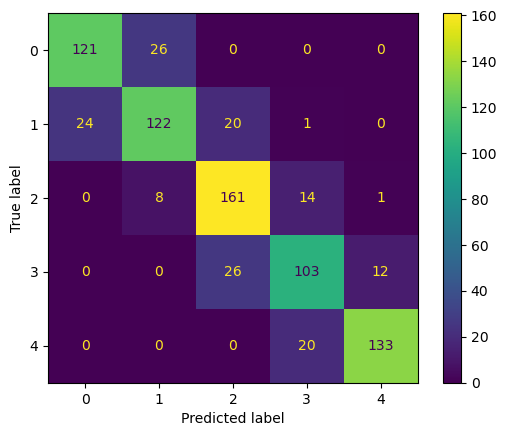

In [75]:
print("meilleurs hyperparam:", best_params)

#entrainement avec hyperparam tuned
final_model = RandomForestClassifier(**best_params, random_state=1)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

#calcul de l'accuracy
test_accuracy = final_model.score(X_test, y_test)
print("precision test:", test_accuracy)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

Now for data_modern:

In [76]:
X = data_modern.drop('Pos', axis=1)
y = data_modern['Pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [77]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,  
    random_state=1  
)

best_params = {}

In [78]:
# hyperparam 1
n_estimators_range = [100, 200, 300, 400]
param_grid = {'n_estimators': n_estimators_range}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params['n_estimators'] = grid_search.best_params_['n_estimators']

In [79]:
# hyperparam 2
max_depth_range = [10, 20, 30, None]
param_grid = {'max_depth': max_depth_range}
rf.set_params(n_estimators=best_params['n_estimators'])  #on sauvegarde l'hyperparam 1
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params['max_depth'] = grid_search.best_params_['max_depth']

meilleurs hyperparam: {'n_estimators': 300, 'max_depth': 30}
precision test: 0.7616060225846926
              precision    recall  f1-score   support

           1       0.88      0.94      0.91       160
           2       0.71      0.67      0.69       164
           3       0.61      0.67      0.64       144
           4       0.76      0.72      0.74       174
           5       0.84      0.81      0.82       155

    accuracy                           0.76       797
   macro avg       0.76      0.76      0.76       797
weighted avg       0.76      0.76      0.76       797

Matrice de confusion :


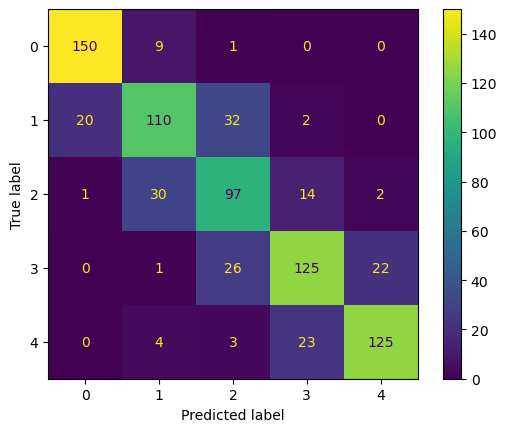

In [80]:
print("meilleurs hyperparam:", best_params)

#entrainement avec hyperparam tuned
final_model = RandomForestClassifier(**best_params, random_state=1)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

#calcul de l'accuracy
test_accuracy = final_model.score(X_test, y_test)
print("precision test:", test_accuracy)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")

ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

While we observed slight improvements in performance, they were minimal, around 0.1% for each dataset, and there were no significant changes in the results. The hyperparameters varied between the two datasets, reflecting the differences in the data characteristics.

To conclude our analysis:

- We observed that it was indeed easier in the past to differentiate between players' positions. The roles were more distinct, allowing clearer classification based on statistical data.

- Point Guards (PGs) today are more unique than before, often being the focal point of the team's offense. This shift has somewhat overshadowed the roles of other positions, making PGs stand out more in statistical analyses.

- The Random Forest algorithm performed exceptionally well compared to other algorithms we tested.

- Having data from 2018 to 2023 would have been beneficial, as the significant shifts in the NBA really started around 2010. This additional data could have provided more insights into recent trends and changes in player roles and performances.

- Creating a 'mid' dataset, representing the 1990s, would have been interesting. This period could have offered a transitional view between the older and modern eras of the NBA. Our hypothesis is that the data from the 90s might closely resemble the 70s in terms of player roles and statistics, but having the actual data could have provided more concrete insights and perhaps revealed transitional trends.